<a href="https://colab.research.google.com/github/BDouchet/StackGan_flickr30k/blob/main/Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **READ DATA**

The dataset is composed of >30k images of size 256x256 mostly representing human interaction. The image format is *.jpg*. A csv file compile the associated captions of the images.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from os import listdir

from keras.optimizers import Adam
from keras import Input, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1BzL7oYRJm8wG0yAMamaUP-wZraD7Qjku'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('flickr30k_images.zip')

with ZipFile('flickr30k_images.zip', 'r') as zip:
   zip.extractall()
   print('Done')

Done


Store the captions into a pandas file

In [100]:
df=pd.read_csv('/content/results.csv',sep='|')
df=df.rename(columns={' comment_number':'comment_number',' comment':'comment'})
print(captions.columns)
df.loc[19999]['comment_number','comment']=[4,'A dog runs across the grass .']
df['comment_number']=pd.to_numeric(df['comment_number'])
df

Index(['image_name', 'comment_number', 'comment'], dtype='object')


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


To get all the filenames

In [101]:
filenames=df.image_name.unique()
filenames

array(['1000092795.jpg', '10002456.jpg', '1000268201.jpg', ...,
       '997876722.jpg', '99804383.jpg', '998845445.jpg'], dtype=object)

In [103]:
captions=df.set_index(['image_name','comment_number'])
captions

comment
image_name     comment_number                                                   
1000092795.jpg 0                Two young guys with shaggy hair look at their...
               1                Two young , White males are outside near many...
               2                Two men in green shirts are standing in a yard .
               3                    A man in a blue shirt standing in a garden .
               4                         Two friends enjoy time spent together .
...                                                                          ...
998845445.jpg  0                A man in shorts and a Hawaiian shirt leans ov...
               1                A young man hanging over the side of a boat ,...
               2                A man is leaning off of the side of a blue an...
               3                A man riding a small boat in a harbor , with ...
               4                A man on a moored blue and white boat with hi...

[158915 rows x 1 columns]

Read an image and its associated caption.

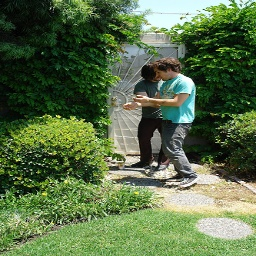

 A man in a blue shirt standing in a garden .


(256, 256, 3)

In [105]:
def read_image_caption(img,number):
    #read the image
    img_path = 'images/'+img
    im=cv2.imread(img_path)
    comment=captions.loc[img,number]['comment']
    return im, comment

img, text = read_image_caption('1000092795.jpg',3)
cv2_imshow(img)
print(text)
img.shape


# **Process images and captions**

## Read 64x64 images


(31783, 64, 64, 3)


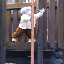

390549648 bytes


In [116]:
def read_images(directory):
  X = []
  for img in listdir(directory):
    X.append(plt.imread(directory+img))
  return np.array(X)

X = read_images('images64/')
print(X.shape)
cv2_imshow(X[0])

from sys import getsizeof
print(str(getsizeof(X))+' bytes')

## Generate the dictionnary

In [117]:
import nltk  
import random  
import string
import bs4 as bs  
import urllib.request  
import re
from os import listdir
nltk.download('stopwords')  
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [132]:
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
stop_words = set(stopwords.words('english'))

def clean_caption(caption):
  tokens = caption.split()  
  tokens = [re_punc.sub('',w) for w in tokens] # enleve les ' et les 
  tokens = [word for word in tokens if word.isalpha()] # enleve les nombres
  tokens = [word for word in tokens if word not in stop_words] # enleve les stopword
  tokens = [word for word in tokens if len(word) > 1] # on conserve les mots dont la taille est supérieur à 1
  return tokens

def save_tokens(tokens, filename):
  data = '\n'.join(tokens)
  file = open(filename, 'w')
  file.write(data)
  file.close()

def process_captions(filenames,vocab):
    for num,file in enumerate(filenames):
        if num%1000==0:
            print(str(num)+'/'+str(len(filenames)))
        for i in range(5):
            _, caption = read_image_caption(file,i)
            tokens = clean_caption(caption)
            vocab.update(tokens)


In [133]:
vocab = Counter()
process_captions(filenames, vocab)

min_occurence = 2
dictionnary = [token for token,count in vocab.items() if count >=min_occurence]
save_tokens(dictionnary, "./dictionnary.txt")
print(len(vocab.items()))

0/31783
1000/31783
2000/31783
3000/31783
4000/31783
5000/31783
6000/31783
7000/31783
8000/31783
9000/31783
10000/31783
11000/31783
12000/31783
13000/31783
14000/31783
15000/31783
16000/31783
17000/31783
18000/31783
19000/31783
20000/31783
21000/31783
22000/31783
23000/31783
24000/31783
25000/31783
26000/31783
27000/31783
28000/31783
29000/31783
30000/31783
31000/31783
22747


In [134]:
print(vocab.most_common(30))

[('man', 40277), ('woman', 21236), ('Two', 16447), ('wearing', 15694), ('people', 14148), ('white', 13039), ('shirt', 12975), ('black', 12084), ('young', 12021), ('blue', 11268), ('red', 9857), ('sitting', 9608), ('girl', 9342), ('boy', 9135), ('standing', 9103), ('dog', 8927), ('men', 8765), ('playing', 8618), ('street', 7902), ('front', 7601), ('group', 7536), ('walking', 7331), ('holding', 6980), ('water', 5938), ('The', 5572), ('one', 5530), ('two', 5194), ('green', 5185), ('looking', 5052), ('child', 4928)]


## Encoding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

def load_vocab(filename):
  file = open(filename, 'r')
  text = file.read()
  return text

def doc_to_line(filename, vocab):
  img, doc = read_image_caption(filename)
  tokens = clean_doc(doc)
  tokens = [token for token in tokens if token in vocab]
  return ' '.join(tokens)

def process_docs(directory, vocab):
  lines = []
  i=0
  for img in listdir(directory):
    print(i)
    line = doc_to_line(img, vocab)
    lines.append(line)
    if i>10000:
      break
    i=i+1
  return lines  

def create_tokenizer(docs):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(docs)
  return tokenizer

def encode_docs(tokenizer, max_length, docs):
  encoded = tokenizer.texts_to_sequences(docs)
  padded = pad_sequences(encoded, maxlen=max_length, padding="post")
  return padded
"""
vocab_filename = './vocab.txt'
vocab = load_vocab(vocab_filename)
vocab = vocab.split()
encoded_caption = process_docs('./images', vocab)
"""

# create the tokenizer
tokenizer = create_tokenizer(caption_np)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)


Vocabulary size: 7865


In [ ]:
caption_np = np.load('data.npy')
print(caption_np[0])
print(caption_np[4])
print(caption_np[5])


The young blondhaired child playing outdoor play gym preparing slide firehouse pole
man wearing coat holding briefcase walking street winter
man holding box orange shirt blue orange striped pants standing multiple wooden boxes


In [ ]:
max_length = 1024
encoded_caption = encode_docs(tokenizer, max_length, caption_np)
print(encoded_caption[0].shape)
print(encoded_caption[0])
print(encoded_caption[4])
print(encoded_caption[5])

(1024,)
[ 38  11 573 ...   0   0   0]
[  1   2 125 ...   0   0   0]
[  1  18 447 ...   0   0   0]


# **Stage I GAN**

## Create the models

A voir si utile

In [ ]:
def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model

Conditioning Augmentation part. We receive an encoded vector (through a word Embedding layer), and we operate random values on it. This allows to increase the latent space of the generated images. The X symbol stands for an element-wise multiplication. 

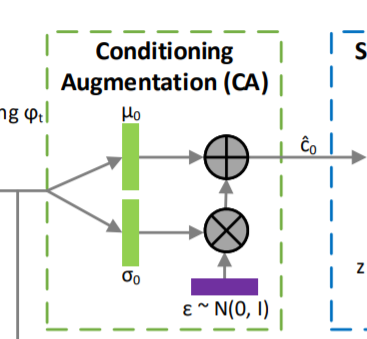

In [ ]:
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c

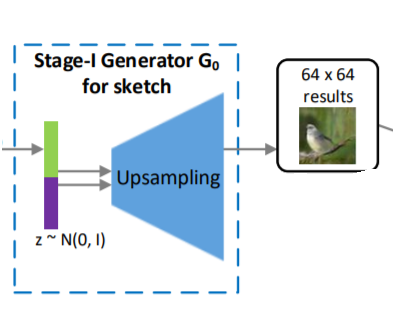

Stage 1 Generator. Consists of 4 upsampling the image followed by a convolution layer :

(4x4,1024) -> (8x8,512) -> (16x16,256) -> (32x32,128) -> (64x64,64) -> (64,64,3)


In [ ]:
MAX_LENGTH=20
VOCAB_SIZE=2000

def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = layers.Input(shape=(1024,))
    #x=layers.Embedding(VOCAB_SIZE, 1024, input_length=MAX_LENGTH)(input_layer)
    x = layers.Dense(256)(input_layer)
    mean_logsigma = layers.LeakyReLU(alpha=0.2)(x)

    c = layers.Lambda(generate_c)(mean_logsigma)

    z = layers.Input(shape=(100,))

    gen_input = layers.Concatenate(axis=1)([c, z])

    x = layers.Dense(128 * 8 * 4 * 4,use_bias=False,activation='relu')(gen_input)
    x = layers.Reshape((4, 4, 128 * 8))(x)

    #(4,4,1024) -> (8,8,512)
    x = layers.UpSampling2D(interpolation='bilinear')(x)
    x = layers.Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    #(8,8,512) -> (16,16,256)
    x = layers.UpSampling2D(interpolation='bilinear')(x)
    x = layers.Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    #(16,16,256) ->  (32,32,128) 
    x = layers.UpSampling2D(interpolation='bilinear')(x)
    x = layers.Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    #(32,32,128) ->  (64,64,64) 
    x = layers.UpSampling2D(interpolation='bilinear')(x)
    x = layers.Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    #(64,64,64) ->  (64,64,3) 
    x = layers.Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False,activation='tanh')(x)

    stage1_gen = models.Model(inputs=[input_layer, z], outputs=[x, mean_logsigma])
    return stage1_gen

print(build_stage1_generator().summary())
#plot_model(build_stage1_generator(),show_shapes=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          262400      input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128)          0           leaky_re_lu_1[0][0]              
_______________________________________________________________________________________

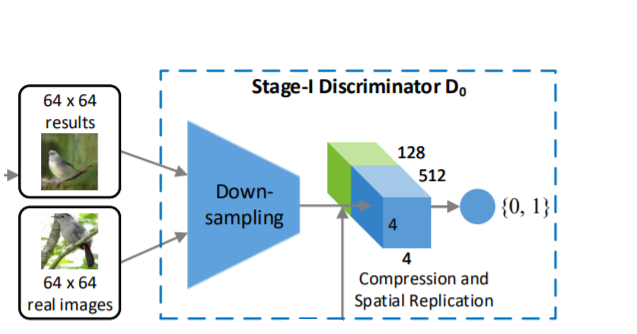

Stage 1 Discriminator

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 64)   3072        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       (None, 32, 32, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 128)  131072      leaky_re_lu_2[0][0]              
_______________________________________________________________________________________

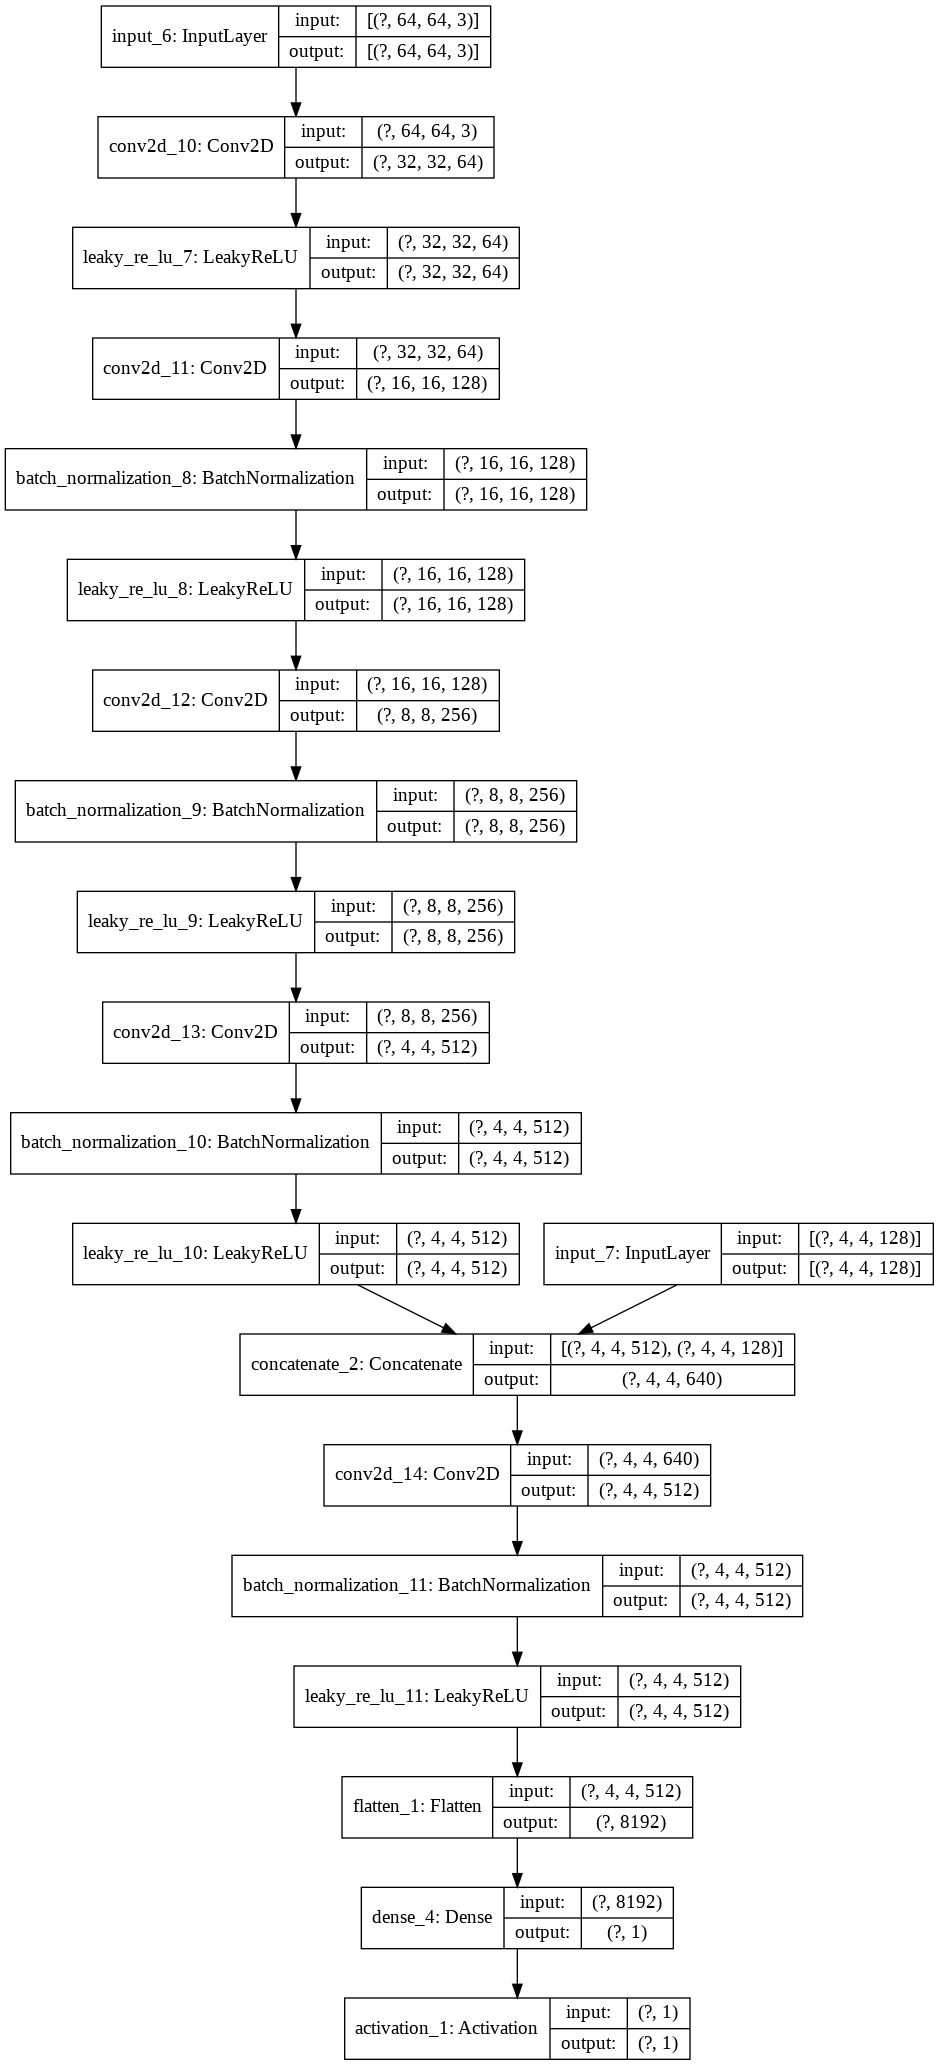

In [ ]:
def build_stage1_discriminator():
    """
    Create a model which takes two inputs
    1. One from above network
    2. One from the embedding layer
    3. Concatenate along the axis dimension and feed it to the last module which produces final logits
    """
    input_layer = layers.Input(shape=(64, 64, 3))

    #(64,64,3) -> (32,32,64)
    x = layers.Conv2D(64, (4, 4), padding='same', strides=2, use_bias=False)(input_layer)
    x = layers.LeakyReLU(alpha=0.2)(x)

    #(32,32,64) -> (16,16,128)
    x = layers.Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    #(16,16,128) -> (8,8,256)
    x = layers.Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    #(8,8,256) -> (4,4,512)
    x = layers.Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    input_layer2 = layers.Input(shape=(4, 4, 128))

    merged_input = layers.Concatenate()([x, input_layer2])

    #(4,4,630) -> (4,4,512)
    x2 = layers.Conv2D(64 * 8, kernel_size=1, padding="same", strides=1)(merged_input)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU(alpha=0.2)(x2)

    #(4,4,512) -> 8192 -> 1
    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(1)(x2)
    x2 = layers.Activation('sigmoid')(x2)

    stage1_dis = models.Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis

print(build_stage1_discriminator().summary())
plot_model(build_stage1_discriminator(),show_shapes=True)


In [ ]:
def build_adversarial_model(gen_model, dis_model):
    input_layer = Input(shape=(1024,))
    input_layer2 = Input(shape=(100,))
    input_layer3 = Input(shape=(4, 4, 128))

    x, mean_logsigma = gen_model([input_layer, input_layer2])

    dis_model.trainable = False
    valid = dis_model([x, input_layer3])

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model

In [ ]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss
    
def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)

## Train 1st Stage GAN

Compiling the models and setting the hyperparameters

In [ ]:
import time

image_size = 64
batch_size = 64
z_dim = 100
stage1_generator_lr = 0.0002
stage1_discriminator_lr = 0.0002
stage1_lr_decay_step = 600
epochs = 300
condition_dim = 128

# Define optimizers
dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

ca_model = build_ca_model()
ca_model.compile(loss="binary_crossentropy", optimizer="adam")

stage1_dis = build_stage1_discriminator()
stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

stage1_gen = build_stage1_generator()
stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

embedding_compressor_model = build_embedding_compressor_model()
embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                              optimizer=gen_optimizer, metrics=None)

tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
tensorboard.set_model(stage1_gen)
tensorboard.set_model(stage1_dis)
tensorboard.set_model(ca_model)
tensorboard.set_model(embedding_compressor_model)


In [ ]:
embeddings_train = encoded_caption

In [ ]:
real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

for epoch in range(epochs):
  print("========================================")
  print("Epoch is:", epoch)
  print("Number of batches", int(X.shape[0] / batch_size))

  gen_losses = []
  dis_losses = []

  # Load data and train model
  number_of_batches = int(X.shape[0] / batch_size)

  for index in range(number_of_batches):
    print("Batch:{}".format(index+1))
    
    """
    Train the discriminator network
    """

    # Sample a batch of data
    z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
    """
    extraire un batch d'images
    extraire un des 5 commentaires associés aux images
    diviser le batch d'images par 255 
    """
    image_batch = X[index * batch_size:(index + 1) * batch_size]
    embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
    image_batch = (image_batch - 127.5) / 127.5

    # Generate fake images
    fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

    # Generate compressed embeddings
    compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
    compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
    compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

    dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
    dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
    dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))

    d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

    print("d_loss_real:{}".format(dis_loss_real))
    print("d_loss_fake:{}".format(dis_loss_fake))
    print("d_loss_wrong:{}".format(dis_loss_wrong))
    print("d_loss:{}".format(d_loss))
    """
    Train the generator network 
    """
    g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
    print("g_loss:{}".format(g_loss))

    dis_losses.append(d_loss)
    gen_losses.append(g_loss)
    """
    
    Save losses to Tensorboard after each epoch
    
    write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
    write_log(tensorboard, 'generator_loss', np.mean(gen_losses[0]), epoch)
    
    # Generate and save images after every 2nd epoch
    if epoch % 2 == 0:
        # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
        embedding_batch = embeddings_test[0:batch_size]
        fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

        # Save images
        for i, img in enumerate(fake_images[:10]):
            save_rgb_img(img, "results/gen_{}_{}.png".format(epoch, i))

    # Save models
    stage1_gen.save_weights("stage1_gen.h5")
    stage1_dis.save_weights("stage1_dis.h5")
    """

KeyboardInterrupt: ignored